In [1]:
from Processing import *
from ImageHandler import *
from ImageProcessing import *
from GeometryProcessing import *

import globalVar

Found 387 components with height 12.142118863049095 in image


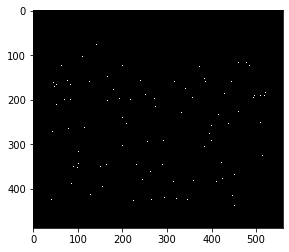

Calculated 110 lines


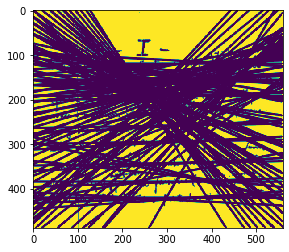

In [2]:
image = loadImage("../Test-data/test.png");
labels, avg_height, centroids, DemoImg, stats = findComponents(image);
linesO = findHoughLines(DemoImg, image, avg_height, 139, 5, 5);

In [3]:
lines = np.copy(linesO);
leftLines = len(lines);
selLines = [];

globalVar.init(lines, centroids);

110 Lines left, 3 Lines in this cluster, Value of primary cell 35, Chosen Line (120.0, 1.5707964)
107 Lines left, 3 Lines in this cluster, Value of primary cell 31, Chosen Line (168.0, 1.535889744758606)
104 Lines left, 2 Lines in this cluster, Value of primary cell 31, Chosen Line (132.0, 1.535889744758606)
102 Lines left, 3 Lines in this cluster, Value of primary cell 31, Chosen Line (156.0, 1.5707963705062866)
99 Lines left, 3 Lines in this cluster, Value of primary cell 30, Chosen Line (348.0, 1.5533430576324463)
96 Lines left, 7 Lines in this cluster, Value of primary cell 28, Chosen Line (420.0, 1.5707963705062866)
89 Lines left, 3 Lines in this cluster, Value of primary cell 25, Chosen Line (204.0, 1.535889744758606)
86 Lines left, 5 Lines in this cluster, Value of primary cell 25, Chosen Line (432.0, 1.535889744758606)
81 Lines left, 3 Lines in this cluster, Value of primary cell 25, Chosen Line (180.0, 1.4311699867248535)
78 Lines left, 4 Lines in this cluster, Value of primar

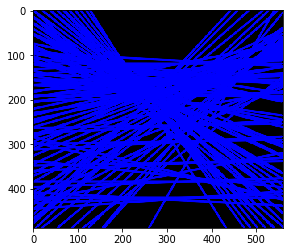

In [4]:
edgyImg = cv.Canny(image, 50, 200, None, 3)
edgyColor = cv.cvtColor(edgyImg, cv.COLOR_GRAY2BGR)
DemoImg = np.zeros_like(edgyColor);
vertices = [];

while (True):
    if (leftLines < 1):
        break
    print (str(leftLines) + " Lines left", end = ", ");
    (rho_, theta_), pos_ = findPrimaryCell(lines, centroids)

    f_clus = findClustersize(theta_, avg_height)

    x0 = rho_ - f_clus
    x1 = rho_ + f_clus
    z0 = theta_ - math.radians(3)
    z1 = theta_ + math.radians(3)

    clusCells, clusPos, lines, stop, vertix = findcells(x0, x1, z0, z1, lines);
    vertices.append(vertix);
    leftLines = leftLines - len(clusCells);

    if (stop):
        break;
    print (str (len(clusCells)) + " Lines in this cluster", end = ", ");
    showLines(clusCells, DemoImg)
    n0 = findValueofcell([(rho_, theta_)], centroids, pos_)
    print ("Value of primary cell " + str(n0), end = ", ");

    ntemp = 0
    rho1, theta1 = 0,0
    lpos1 = 0;
    for pos in range(len(clusCells)):
        i = clusCells[pos];
        if (i[0][0] == rho_ and i[0][1] == theta_):
            continue
        temp = findValueofcell(i, centroids, pos)
        if (temp > ntemp):
            ntemp = temp
            rho1 = i[0][0]
            theta1 = i[0][1]
            lpos1 = clusPos[pos];

    (rhon, thetan) , pos = compareValueinStruct([(rho_, theta_)], pos_, [(rho1, theta1)], lpos1, centroids, x0, x1, z0, z1, n0, ntemp)

    print ("Chosen Line " + str((rhon, thetan)));
    selLines.append((rhon, thetan));

In [10]:
len(selLines)

51

In [11]:
data = [];
lineData = [];
remove = 0;

for i in range(len(selLines)):
    print ("Working for line " + str(i + 1) + " of " + str(len(selLines)), end = '\r');
    line = selLines[i];
    x1, x2, y1, y2 = findLine(line[0], line[1])
    lineF = Line((x1,y1),(x2,y2));
    labelDataCont = [];
    labelDataNCont = [];
    for i in range(len(stats)):
        stat = stats[i];
        if (stat[4] > 350 or stat[4] < 20):
            remove += 1;
            continue;
        centroid = centroids[i];
        
        x1, y1 = (int (stat[0]          ), int (stat[1]          ))
        x2, y2 = (int (stat[0] + stat[2]), int (stat[1]          ))
        x3, y3 = (int (stat[0] + stat[2]), int (stat[1] + stat[3]))
        x4, y4 = (int (stat[0]          ), int (stat[1] + stat[3]))

        segment1 = Segment((x1, y1), (x2, y2));
        segment2 = Segment((x2, y2), (x3, y3));
        segment3 = Segment((x3, y3), (x4, y4));
        segment4 = Segment((x4, y4), (x1, y1));

        i1 = lineF.intersection(segment1)
        i2 = lineF.intersection(segment2)
        i3 = lineF.intersection(segment3)
        i4 = lineF.intersection(segment4)

        # Only put if line intersects this component
        if (not (len(i1) == 0 and len(i2) == 0 and len(i3) == 0 and len(i4) == 0)):
            labelDataCont.append([[stat],[centroid],[i1,i2,i3,i4]]);
        else:
            labelDataNCont.append([[stat], [centroid]]);

    lineData.append([labelDataCont,labelDataNCont]);
data.append(lineData);

In [13]:
backupData = data.copy()

In [ ]:
validLines = [];
for k in range(len(data[0])):
    line = data[0][k];
    line[0] = sort (line[0]);
    if len(line[0]) > 2 :
        intNeigh = (len(line[0]) - 2) * 2 + 2;
    else:
        intNeigh = len(line[0]);
    extNeigh = 0;
    for i in range(1, len(line[0]) - 1):
        comp = line[0][i];
        extDistance = extDist(line[0], i);
        
        print ("External Distance : " + str(int(extDistance)), end = '\r');

        for j in range(len(line[1])):
            stat = line[1][j];
            if (stat == []):
                continue;
            dist = findDistanceBWcomphere(comp[1][0], stat[1][0], comp[0][0], stat[0][0]);

            if (dist < extDistance):
                extNeigh += 1;
                line[1][j] = [];
    print ("External neighbour : " + str(extNeigh) + " Internal neighbour: " + str(intNeigh))
    if (extNeigh > intNeigh):
        validLines.append([selLines[k]]);


External neighbour : 28 Internal neighbour: 28
External neighbour : 80 Internal neighbour: 30
External neighbour : 37 Internal neighbour: 42
External neighbour : 50 Internal neighbour: 20
External neighbour : 56 Internal neighbour: 38
External neighbour : 20 Internal neighbour: 34
External neighbour : 76 Internal neighbour: 30
External neighbour : 22 Internal neighbour: 32
External neighbour : 27 Internal neighbour: 12
External neighbour : 79 Internal neighbour: 32
External neighbour : 77 Internal neighbour: 30
External neighbour : 35 Internal neighbour: 38
External neighbour : 95 Internal neighbour: 32
External neighbour : 72 Internal neighbour: 24
External neighbour : 91 Internal neighbour: 30
External neighbour : 56 Internal neighbour: 30
External neighbour : 78 Internal neighbour: 26
External neighbour : 70 Internal neighbour: 24
External neighbour : 70 Internal neighbour: 22
External neighbour : 94 Internal neighbour: 40
External neighbour : 73 Internal neighbour: 40


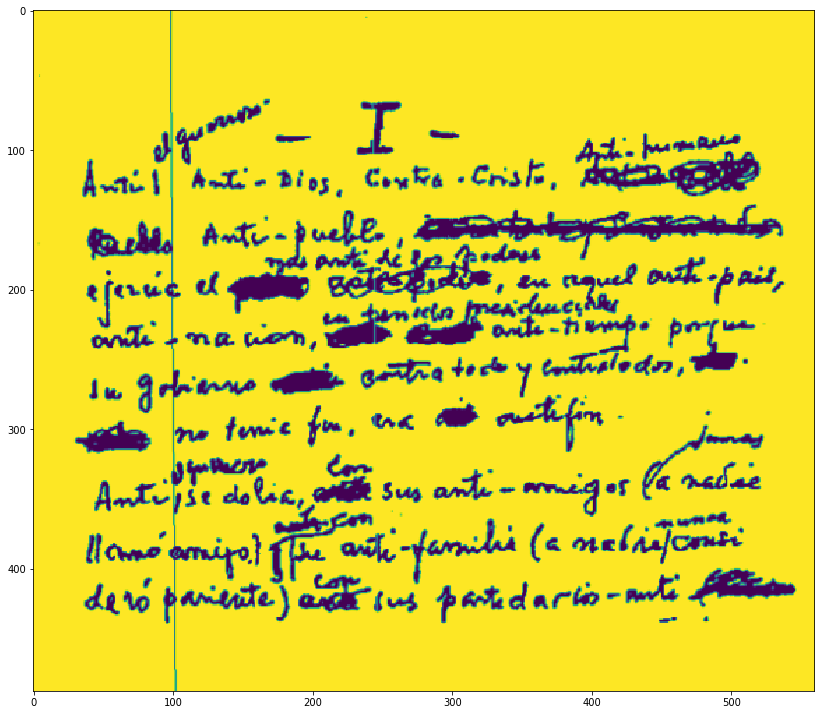

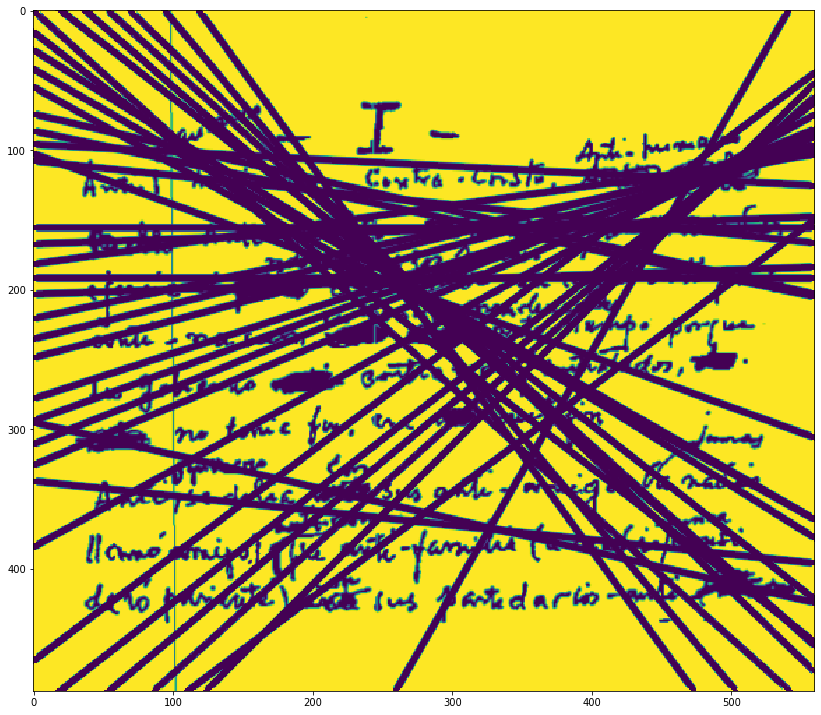

In [59]:
image = loadImage("../Test-data/test.png");
edgyImg = cv.Canny(image, 50, 200, None, 3)
edgyColor = cv.cvtColor(edgyImg, cv.COLOR_GRAY2BGR)
DemoImg = np.zeros_like(edgyColor);

showLines(validLines, image);

In [77]:
data

[]

In [252]:
selLines[0]

(120.0, 1.5707964)

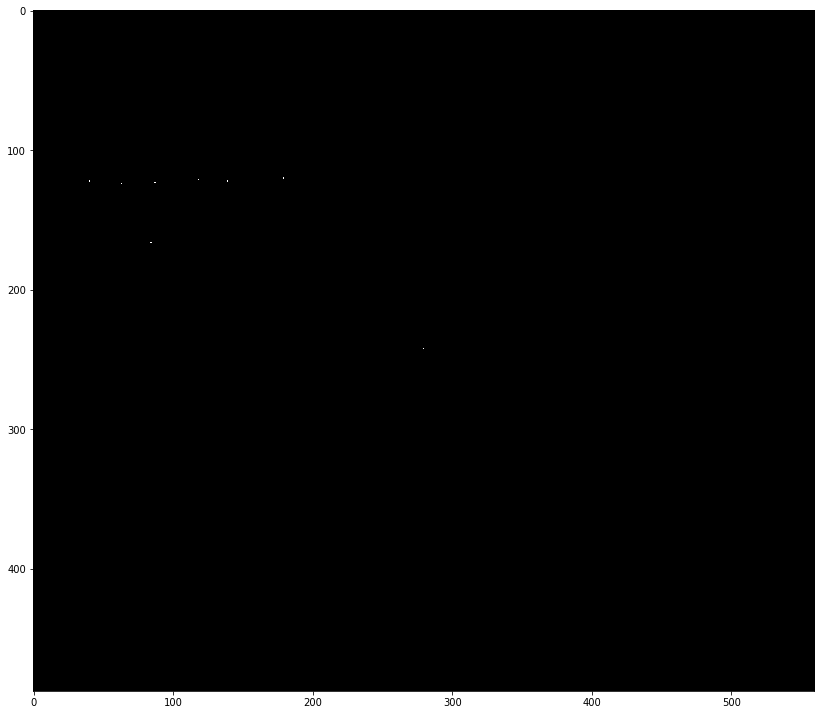

In [47]:
DemoImg[int(data[0][0][0][0][1][0][1]), int(data[0][0][0][0][1][0][0])] = [255,255,255]
DemoImg[int(data[0][0][0][1][1][0][1]), int(data[0][0][0][1][1][0][0])] = [255,255,255]
DemoImg[int(data[0][0][0][2][1][0][1]), int(data[0][0][0][2][1][0][0])] = [255,255,255]
DemoImg[int(data[0][0][0][3][1][0][1]), int(data[0][0][0][3][1][0][0])] = [255,255,255]
DemoImg[int(data[0][0][0][4][1][0][1]), int(data[0][0][0][4][1][0][0])] = [255,255,255]
DemoImg[int(data[0][0][0][5][1][0][1]), int(data[0][0][0][5][1][0][0])] = [255,255,255]
DemoImg[int(data[0][0][0][6][1][0][1]), int(data[0][0][0][6][1][0][0])] = [255,255,255]
DemoImg[int(data[0][0][0][7][1][0][1]), int(data[0][0][0][7][1][0][0])] = [255,255,255]
plt.imshow(DemoImg)
plt.show()

In [55]:
data[0][0][0][6]

[[array([126, 115,  26,  14,  97], dtype=int32)],
 [array([139.20618557, 122.49484536])],
 [[Point2D(126, 239007/1999)],
  [Point2D(1004994/7003, 837363/7003)],
  [Point2D(152, 239033/1999)],
  [Point2D(940033/6990, 835777/6990)]]]

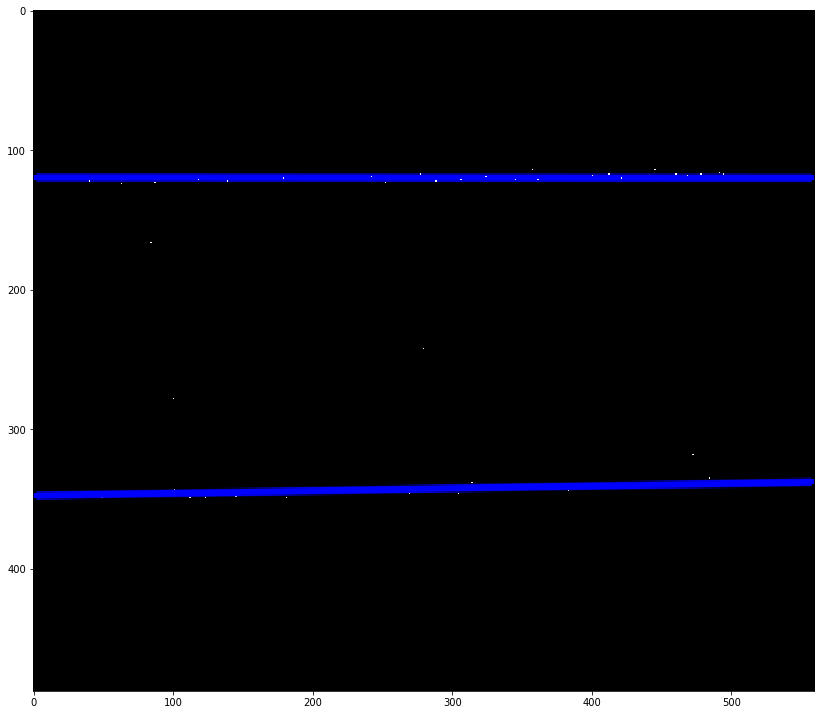

In [39]:
showLines([[selLines[4]]], DemoImg)

In [81]:
edgyImg = cv.Canny(image, 50, 200, None, 3)
edgyColor = cv.cvtColor(edgyImg, cv.COLOR_GRAY2BGR)

DemoImg = np.zeros_like(edgyColor);


In [6]:
rcParams['figure.figsize'] = 14, 28

In [38]:
selLines[4]

(348.0, 1.5533430576324463)

In [61]:
area = 0;
for stat in stats:
    area += stat[4]

In [63]:
area/387

706.1498708010336

In [65]:
## write code for which components to consider and which not to.

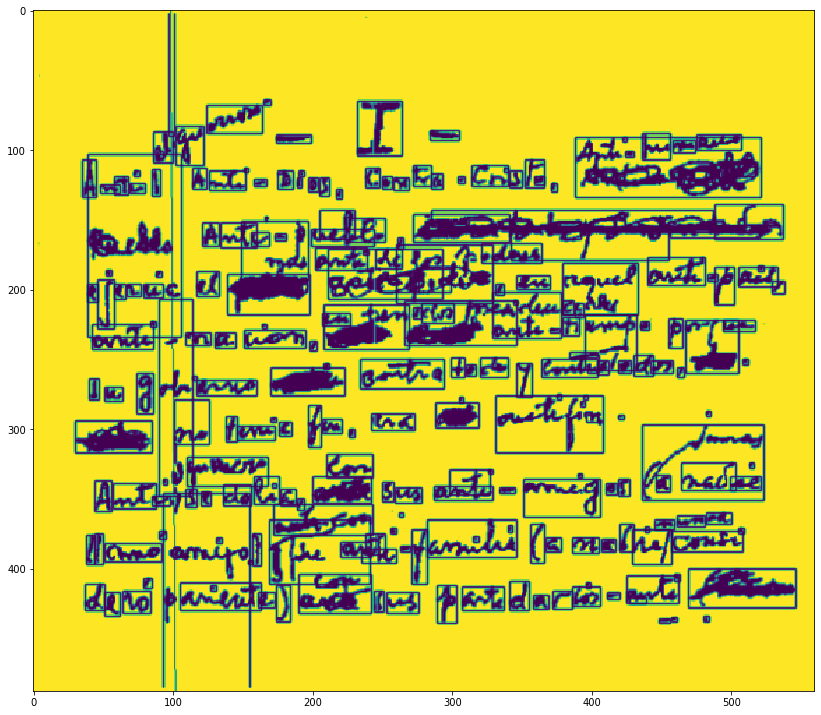

In [9]:
image = loadImage("../Test-data/test.png");
edgyImg = cv.Canny(image, 50, 200, None, 3)
edgyColor = cv.cvtColor(edgyImg, cv.COLOR_GRAY2BGR)
DemoImg = np.zeros_like(edgyColor);

for stat in stats:
    pt1 = (stat[0]          , stat[1]          )
    pt2 = (stat[0] + stat[2], stat[1]          )
    pt3 = (stat[0] + stat[2], stat[1] + stat[3])
    pt4 = (stat[0]          , stat[1] + stat[3])
    cv.line(image, pt1, pt2, (0,0,255), 1, cv.LINE_AA)
    cv.line(image, pt2, pt3, (0,0,255), 1, cv.LINE_AA)
    cv.line(image, pt3, pt4, (0,0,255), 1, cv.LINE_AA)
    cv.line(image, pt4, pt1, (0,0,255), 1, cv.LINE_AA)
plt.imshow(image);

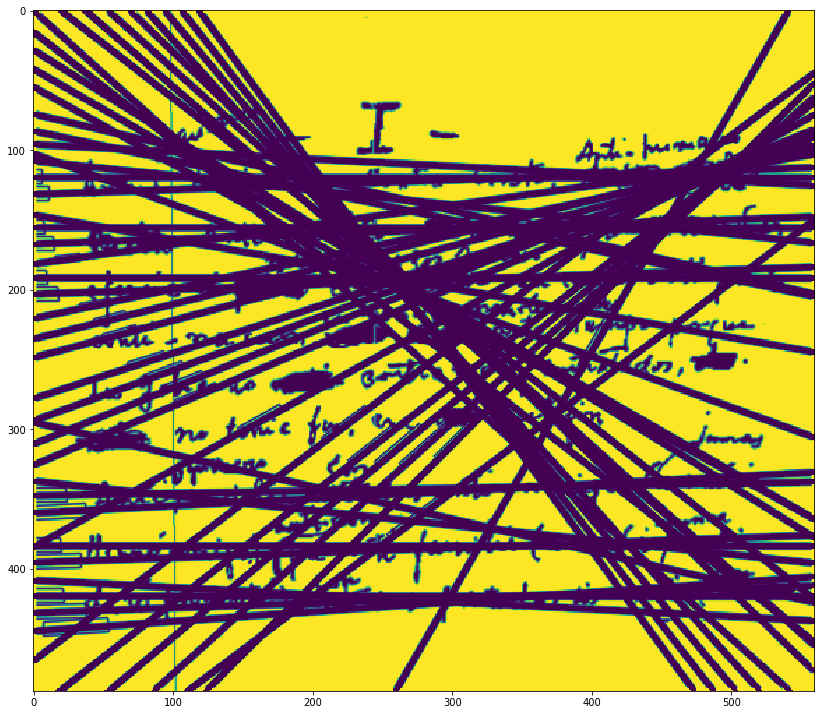

In [8]:
edgyImg = cv.Canny(image, 50, 200, None, 3)
edgyColor = cv.cvtColor(edgyImg, cv.COLOR_GRAY2BGR)
DemoImg = np.zeros_like(edgyColor);
for line in selLines:
    rho = line[0]
    theta = line[1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv.line(image, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
plt.imshow(image);

In [5]:
vertices

[[(6.019, 114.842), (-6.019, 114.842), (6.542, 124.829), (-6.542, 124.829)],
 [(14.206, 162.38), (-2.845, 162.975), (15.078, 172.342), (-3.019, 172.974)],
 [(11.069, 126.517), (-2.216, 126.981), (11.94, 136.479), (-2.391, 136.979)],
 [(7.903, 150.793), (-7.903, 150.793), (8.426, 160.779), (-8.426, 160.779)],
 [(23.926, 342.164), (-11.971, 342.791), (24.624, 352.14), (-12.32, 352.785)],
 [(21.719, 414.431),
  (-21.719, 414.431),
  (22.243, 424.418),
  (-22.243, 424.418)],
 [(17.344, 198.243), (-3.473, 198.97), (18.216, 208.205), (-3.648, 208.968)],
 [(37.216, 425.375), (-7.452, 426.935), (38.087, 435.337), (-7.627, 436.933)]]

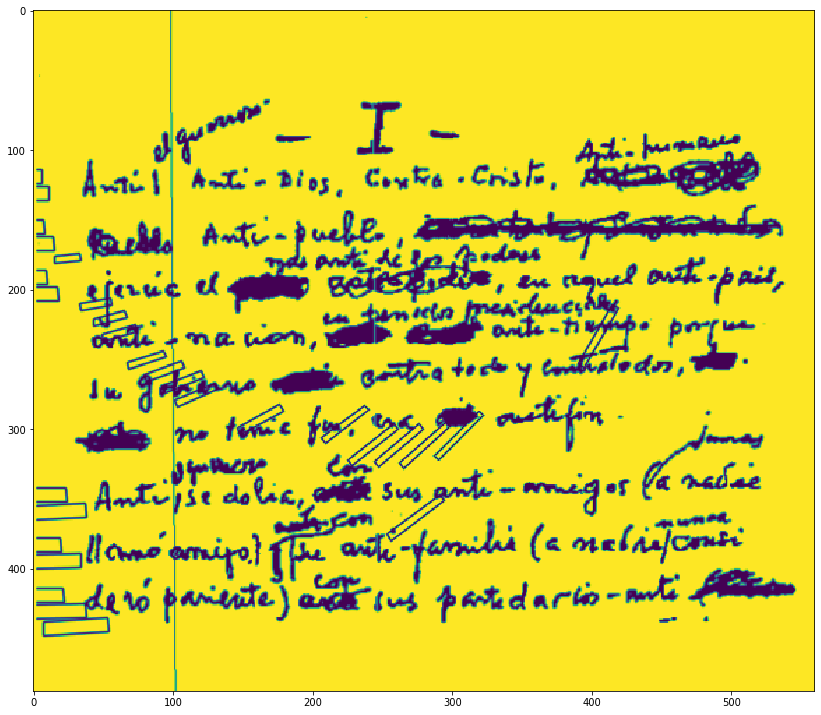

In [7]:
image = loadImage("../Test-data/test.png");
edgyImg = cv.Canny(image, 50, 200, None, 3)
edgyColor = cv.cvtColor(edgyImg, cv.COLOR_GRAY2BGR)
DemoImg = np.zeros_like(edgyColor);

for vertix in vertices:
    vertix = [(int (v[0]),int (v[1])) for v in vertix];
    pt1 = vertix[0]
    pt2 = vertix[1]
    pt3 = vertix[3]
    pt4 = vertix[2]
    cv.line(image, pt1, pt2, (0,0,255), 1, cv.LINE_AA)
    cv.line(image, pt2, pt3, (0,0,255), 1, cv.LINE_AA)
    cv.line(image, pt3, pt4, (0,0,255), 1, cv.LINE_AA)
    cv.line(image, pt4, pt1, (0,0,255), 1, cv.LINE_AA)
plt.imshow(image);

In [19]:
def findDistanceBWcomphere(comp1, comp2, stat1, stat2):
    point1 = Point (int (comp1[0]), int (comp1[1]))
    point2 = Point (int (comp2[0]), int (comp2[1]))
    lineF = Line(point1, point2)
    
    pt1 = (int (stat1[0]           ), int (stat1[1]           ))
    pt2 = (int (stat1[0] + stat1[2]), int (stat1[1]           ))
    pt3 = (int (stat1[0] + stat1[2]), int (stat1[1] + stat1[3]))
    pt4 = (int (stat1[0]           ), int (stat1[1] + stat1[3]))

    segment11 = Segment(pt1, pt2);
    segment12 = Segment(pt2, pt3);
    segment13 = Segment(pt3, pt4);
    segment14 = Segment(pt4, pt1);
    
    pt1 = (int (stat2[0]           ), int (stat2[1]           ))
    pt2 = (int (stat2[0] + stat2[2]), int (stat2[1]           ))
    pt3 = (int (stat2[0] + stat2[2]), int (stat2[1] + stat2[3]))
    pt4 = (int (stat2[0]           ), int (stat2[1] + stat2[3]))

    segment21 = Segment(pt1, pt2);
    segment22 = Segment(pt2, pt3);
    segment23 = Segment(pt3, pt4);
    segment24 = Segment(pt4, pt1); 
    
    i1 = [lineF.intersection(segment11), lineF.intersection(segment12), lineF.intersection(segment13), lineF.intersection(segment14)]
    i2 = [lineF.intersection(segment21), lineF.intersection(segment22), lineF.intersection(segment23), lineF.intersection(segment24)]

    smallest = 9999999;
    
    for i in i1:
        if (len(i) == 0):
            continue;
        for j in i2:
            if (len(j) == 0):
                continue;
            e2eDist = i[0].distance(j[0]);
            if (e2eDist < smallest):
                smallest = e2eDist;
    
    return int (smallest);